## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Dependancies

In [3]:
!pip install --quiet pandas numpy scikit-learn lightgbm xgboost matplotlib requests holidays

In [4]:
import os, pandas as pd, numpy as np
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays
import matplotlib.pyplot as plt

## Loading Data

In [5]:
DATA_DIR = "/content/drive/MyDrive/blueBikeModel/data"
trips = pd.read_csv(f"{DATA_DIR}/202505-bluebikes-tripdata.csv", parse_dates=["started_at"])
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6D667CB9889AB564,classic_bike,2025-05-02 17:49:21.907,2025-05-02 17:54:06.090,Tremont St at E Berkeley St,C32000,Harrison Ave at Bennet St,D32043,42.345392,-71.069616,42.349426,-71.062100,member
1,8E73EF629D56E1CB,classic_bike,2025-05-02 22:30:43.944,2025-05-02 22:42:11.663,Tremont St at E Berkeley St,C32000,Prudential Center - 101 Huntington Ave,C32007,42.345392,-71.069616,42.346520,-71.080658,member
2,4C6CF8C29E531131,electric_bike,2025-05-29 09:18:59.264,2025-05-29 09:30:32.376,MIT Pacific St at Purrington St,M32041,Prudential Center - 101 Huntington Ave,C32007,42.359573,-71.101295,42.346520,-71.080658,member
3,DE15CCD91073DAF5,classic_bike,2025-05-08 18:28:51.554,2025-05-08 18:30:36.958,MIT Pacific St at Purrington St,M32041,University Park,M32040,42.359573,-71.101295,42.362648,-71.100061,member
4,477AFDA6D4404711,classic_bike,2025-05-12 08:54:03.697,2025-05-12 09:05:41.206,Brighton Ave at Linden St,D32058,Harvard Square at Brattle St / Eliot St,M32017,42.352838,-71.129675,42.373329,-71.120986,member


## Visualization


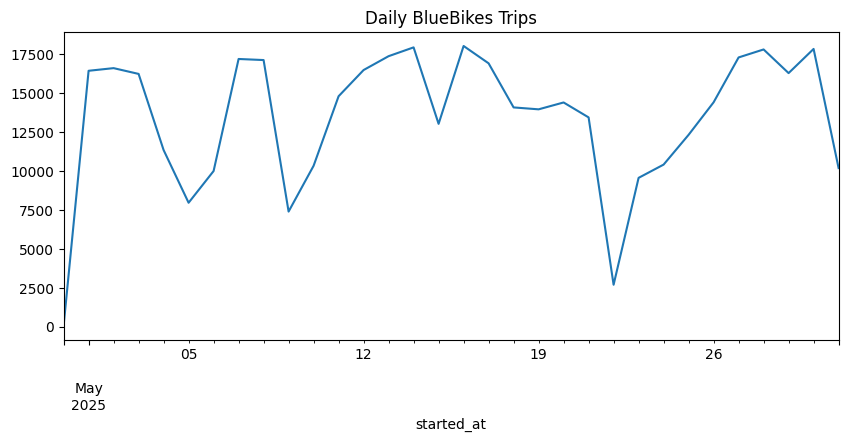

made it this far


In [6]:
# Trips per day
daily = trips.set_index("started_at").resample("D").size()
daily.plot(title="Daily BlueBikes Trips", figsize=(10,4))
plt.show()

# Histogram of durations
#trips["duration_min"] = trips["duration_sec"] / 60
print("made it this far")

## Feature Engineering

In [7]:
trips["hour"]       = trips.started_at.dt.hour
trips["dayofweek"]  = trips.started_at.dt.dayofweek
trips["month"]      = trips.started_at.dt.month
trips["is_weekend"] = trips.dayofweek.isin([5,6]).astype(int)

us_holidays = holidays.US()
trips["date"]       = trips.started_at.dt.date
trips["is_holiday"] = trips["date"].isin(us_holidays).astype(int)

trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,hour,dayofweek,month,is_weekend,date,is_holiday
0,6D667CB9889AB564,classic_bike,2025-05-02 17:49:21.907,2025-05-02 17:54:06.090,Tremont St at E Berkeley St,C32000,Harrison Ave at Bennet St,D32043,42.345392,-71.069616,42.349426,-71.062100,member,17,4,5,0,2025-05-02,0
1,8E73EF629D56E1CB,classic_bike,2025-05-02 22:30:43.944,2025-05-02 22:42:11.663,Tremont St at E Berkeley St,C32000,Prudential Center - 101 Huntington Ave,C32007,42.345392,-71.069616,42.346520,-71.080658,member,22,4,5,0,2025-05-02,0
2,4C6CF8C29E531131,electric_bike,2025-05-29 09:18:59.264,2025-05-29 09:30:32.376,MIT Pacific St at Purrington St,M32041,Prudential Center - 101 Huntington Ave,C32007,42.359573,-71.101295,42.346520,-71.080658,member,9,3,5,0,2025-05-29,0
3,DE15CCD91073DAF5,classic_bike,2025-05-08 18:28:51.554,2025-05-08 18:30:36.958,MIT Pacific St at Purrington St,M32041,University Park,M32040,42.359573,-71.101295,42.362648,-71.100061,member,18,3,5,0,2025-05-08,0
4,477AFDA6D4404711,classic_bike,2025-05-12 08:54:03.697,2025-05-12 09:05:41.206,Brighton Ave at Linden St,D32058,Harvard Square at Brattle St / Eliot St,M32017,42.352838,-71.129675,42.373329,-71.120986,member,8,0,5,0,2025-05-12,0


In [8]:
trips = trips[["rideable_type", "hour", "date", "dayofweek", "month", "is_weekend", "is_holiday"]]
trips.head()

,rideable_type,hour,date,dayofweek,month,is_weekend,is_holiday
0,classic_bike,17,2025-05-02,4,5,0,0
1,classic_bike,22,2025-05-02,4,5,0,0
2,electric_bike,9,2025-05-29,3,5,0,0
3,classic_bike,18,2025-05-08,3,5,0,0
4,classic_bike,8,2025-05-12,0,5,0,0


In [9]:
summary = (
    trips
    .groupby(
        ['date','hour','dayofweek','is_weekend','is_holiday'],
        as_index=False
    )
    .agg(
        electric_bike  = ('rideable_type', lambda x: (x == 'electric_bike').sum()),
        classic_bike   = ('rideable_type', lambda x: (x == 'classic_bike').sum()),
        total_trips    = ('rideable_type', 'size')
    )
)

# Inspect
summary.head(20)

,date,hour,dayofweek,is_weekend,is_holiday,electric_bike,classic_bike,total_trips
0,2025-04-30,3,2,0,0,0,2,2
1,2025-04-30,8,2,0,0,0,1,1
2,2025-04-30,9,2,0,0,0,1,1
3,2025-04-30,16,2,0,0,0,1,1
4,2025-04-30,17,2,0,0,0,2,2
5,2025-04-30,18,2,0,0,0,1,1
6,2025-04-30,19,2,0,0,0,3,3
7,2025-04-30,21,2,0,0,0,2,2
8,2025-04-30,22,2,0,0,1,1,2
9,2025-04-30,23,2,0,0,6,21,27


#Pivot Summary

In [9]:
pivot = (
    trips
    .pivot_table(
        index   = ['date','hour','dayofweek','is_weekend','is_holiday'],
        columns = 'rideable_type',
        aggfunc = 'size',
        fill_value = 0
    )
    .reset_index()
)

# Rename the automatically created columns if needed:
pivot = pivot.rename(columns={
    'classic_bike': 'classic_bike',
    'electric_bike': 'electric_bike'
})

# Add a total-trips column:
pivot['total_trips'] = pivot['classic_bike'] + pivot['electric_bike']

pivot.head()

rideable_type,date,hour,dayofweek,is_weekend,is_holiday,classic_bike,electric_bike,total_trips
0,2025-04-30,3,2,0,0,2,0,2
1,2025-04-30,8,2,0,0,1,0,1
2,2025-04-30,9,2,0,0,1,0,1
3,2025-04-30,16,2,0,0,1,0,1
4,2025-04-30,17,2,0,0,2,0,2


In [10]:
# Correlations
summary2 = summary[['hour', 'dayofweek', 'is_weekend', 'is_holiday', 'electric_bike', 'classic_bike', 'total_trips']]
summary2.corr()

,hour,dayofweek,is_weekend,is_holiday,electric_bike,classic_bike,total_trips
hour,1.000000,-0.004396,-0.004971,NaN,0.456037,0.424015,0.436450
dayofweek,-0.004396,1.000000,0.774932,NaN,-0.019620,-0.036111,-0.032609
is_weekend,-0.004971,0.774932,1.000000,NaN,-0.042776,-0.037747,-0.039371
is_holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
electric_bike,0.456037,-0.019620,-0.042776,NaN,1.000000,0.937560,0.963070
classic_bike,0.424015,-0.036111,-0.037747,NaN,0.937560,1.000000,0.996588
total_trips,0.436450,-0.032609,-0.039371,NaN,0.963070,0.996588,1.000000


In [11]:
summary.tail()

,date,hour,dayofweek,is_weekend,is_holiday,electric_bike,classic_bike,total_trips
749,2025-05-31,19,5,1,0,177,429,606
750,2025-05-31,20,5,1,0,91,197,288
751,2025-05-31,21,5,1,0,83,133,216
752,2025-05-31,22,5,1,0,83,114,197
753,2025-05-31,23,5,1,0,51,125,176


## Train/Test Split & Baseline

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_squared_error, mean_absolute_error, r2_score

In [13]:
X = summary[['hour','dayofweek','is_weekend','is_holiday']]
y = summary['total_trips']

In [14]:
cutoff = summary['date'].max() - pd.Timedelta(days=6)
train_df = summary[summary['date'] <= cutoff]
test_df  = summary[summary['date']  > cutoff]

X_train = train_df[['hour','dayofweek','is_weekend','is_holiday']]
y_train = train_df['total_trips']
X_test  = test_df [['hour','dayofweek','is_weekend','is_holiday']]
y_test  = test_df ['total_trips']

In [15]:
import warnings
import pandas as pd
from sklearn.utils       import all_estimators
from sklearn.model_selection import TimeSeriesSplit, cross_validate

# 1) Suppress spurious warnings
warnings.filterwarnings('ignore')

# 2) Prepare a time-series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# 3) Loop through every regressor, capturing MAE & RMSE
results = []
for name, Regressor in all_estimators(type_filter='regressor'):
    try:
        model = Regressor()  # default init; you can pass random_state=42 for some
        cv_res = cross_validate(
            model,
            X_train, y_train,
            cv=tscv,
            scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error'),
            error_score='raise'   # fail hard if something’s really broken
        )
        results.append({
            'model': name,
            'MAE' : -cv_res['test_neg_mean_absolute_error'].mean(),
            'RMSE': -cv_res['test_neg_root_mean_squared_error'].mean()
        })
    except Exception:
        # skip models that error out (e.g. require special data formats)
        continue

# 4) Build and display the leaderboard
leaderboard = pd.DataFrame(results).sort_values('MAE').reset_index(drop=True)
leaderboard.head(10)

,model,MAE,RMSE
0,RadiusNeighborsRegressor,208.208502,334.591306
1,KNeighborsRegressor,215.325439,346.695192
2,BaggingRegressor,228.191583,374.363318
3,GaussianProcessRegressor,230.500743,384.382213
4,RandomForestRegressor,231.781506,379.828430
5,ExtraTreesRegressor,234.226020,387.151973
6,ExtraTreeRegressor,235.788377,388.915623
7,DecisionTreeRegressor,236.297149,390.144094
8,HistGradientBoostingRegressor,237.858905,363.269444
9,GradientBoostingRegressor,240.586861,367.047932


#Tuning and Hyperperamters

Tuning a RadiusNeighborsRegressor boils down to finding the sweet spot for:

radius: how far in feature-space you look for neighbors

weights: whether to weight all neighbors equally or inversely by distance

metric (and its sub‐parameters like p for Minkowski)

leaf_size: the tree‐based index leaf size under the hood (affects speed)

Below is a step-by-step recipe—using GridSearchCV with a time-series split—to systematically search these hyperparameters on your bike-demand data:

In [16]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# 1. Define your base regressor
rnr = RadiusNeighborsRegressor()

# 2. Create a time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 3. Build a parameter grid to search
param_grid = {
    "radius":      [0.5, 1.0, 2.0, 5.0, 10.0],        # try small → large radii
    "weights":     ["uniform", "distance"],           # equal vs. inverse-distance
    "metric":      ["euclidean", "manhattan"],        # two common norms
    "leaf_size":   [20, 30, 40],                      # controls indexing speed/accuracy
    # if you use 'minkowski', you can also tune 'p':[1,2]
}

# 4. Choose your scoring metric (here MAE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 5. Set up the grid search
grid = GridSearchCV(
    estimator   = rnr,
    param_grid  = param_grid,
    cv          = tscv,
    scoring     = mae_scorer,
    n_jobs      = -1,
    verbose     = 2
)

# 6. Fit on your training data
grid.fit(X_train, y_train)

# 7. Inspect the best parameters and best score
print("Best MAE (negative):", grid.best_score_)
print("Best params:       ", grid.best_params_)

# 8. Retrieve the tuned model
best_rnr = grid.best_estimator_

# 9. Evaluate on the hold-out test set
y_pred = best_rnr.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best MAE (negative): -220.85925663478278
Best params:        {'leaf_size': 20, 'metric': 'manhattan', 'radius': 5.0, 'weights': 'distance'}
Test MAE: 184.75868055555554


Visualization

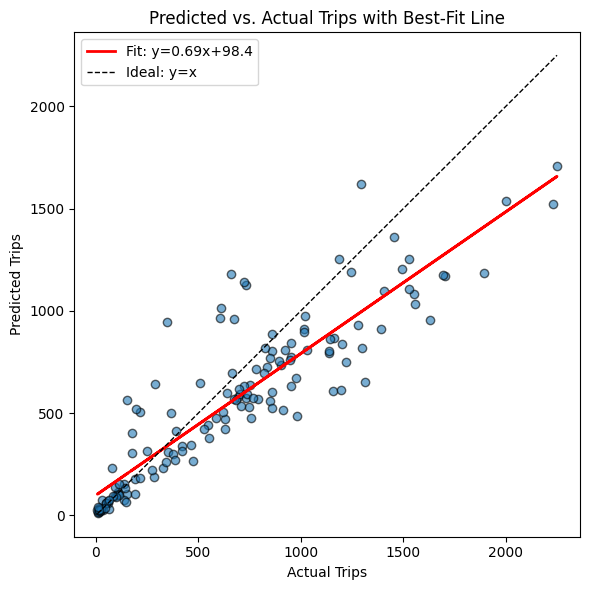

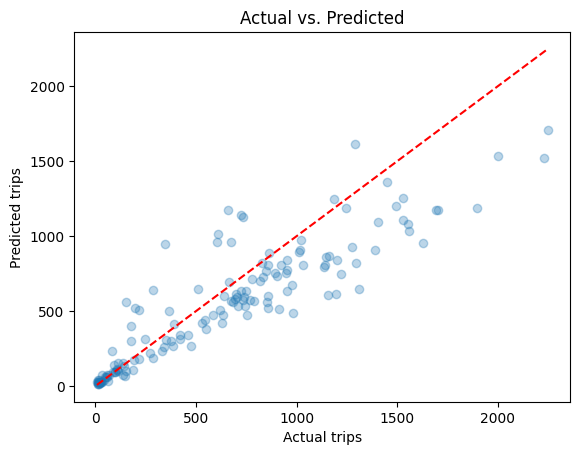

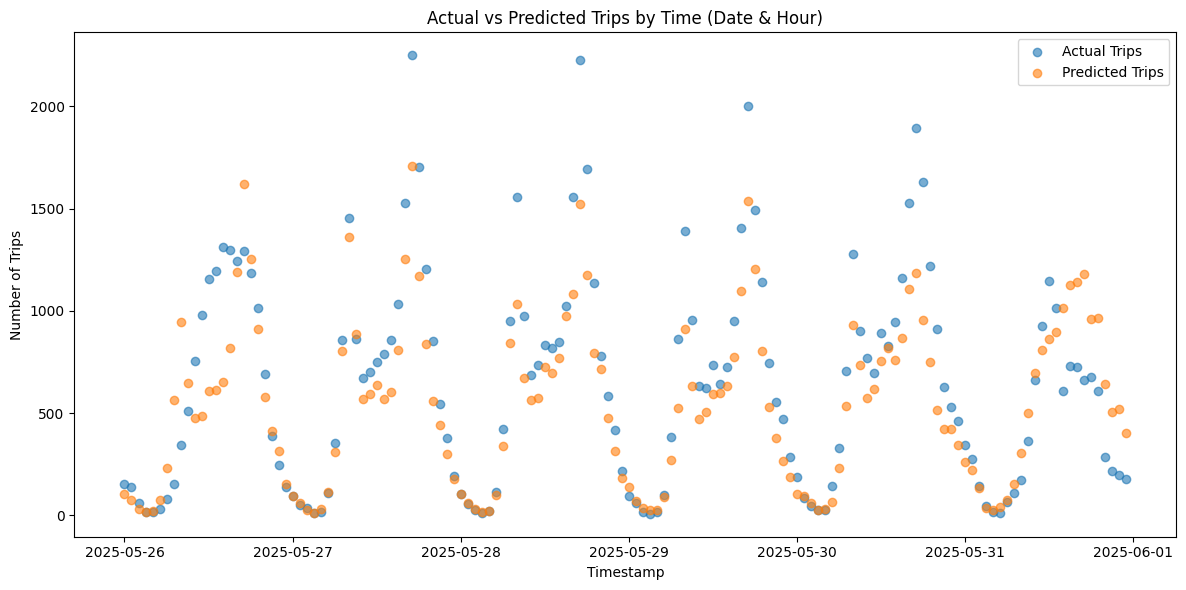

In [18]:
# Extract the two series
actual    = test_with_preds['total_trips'].to_numpy()
predicted = test_with_preds['predicted_trips'].to_numpy()

# 1) Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(actual, predicted, alpha=0.6, edgecolor='k')

# 2) Best-fit line via 1st-degree polyfit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(actual, m*actual + b, color='red', linewidth=2, label=f'Fit: y={m:.2f}x+{b:.1f}')

# 3) 1:1 reference line (perfect prediction)
minv, maxv = actual.min(), actual.max()
plt.plot([minv, maxv], [minv, maxv], 'k--', linewidth=1, label='Ideal: y=x')

plt.xlabel('Actual Trips')
plt.ylabel('Predicted Trips')
plt.title('Predicted vs. Actual Trips with Best-Fit Line')
plt.legend()
plt.tight_layout()
plt.show()

##

plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual trips")
plt.ylabel("Predicted trips")
plt.title("Actual vs. Predicted")
plt.show()

test_with_preds = test_df.copy()

test_with_preds['predicted_trips'] = y_pred

df = test_with_preds.copy()
df['timestamp'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# 2. Plot
plt.figure(figsize=(12, 6))
plt.scatter(df['timestamp'], df['total_trips'],    label='Actual Trips',    alpha=0.6)
plt.scatter(df['timestamp'], df['predicted_trips'], label='Predicted Trips', alpha=0.6)
plt.xlabel('Timestamp')
plt.ylabel('Number of Trips')
plt.title('Actual vs Predicted Trips by Time (Date & Hour)')
plt.legend()
plt.tight_layout()
plt.show()

## Train a Linear Regression Model

#Linear stuff

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Visualize Predictions


In [16]:
y_pred = lr.predict(X_test)

test_with_preds = test_df.copy()

test_with_preds['predicted_trips'] = y_pred

print(test_with_preds)

mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.3f}")



           date  hour  dayofweek  is_weekend  is_holiday  electric_bike  \
610  2025-05-26     0          0           0           0             52   
611  2025-05-26     1          0           0           0             42   
612  2025-05-26     2          0           0           0             18   
613  2025-05-26     3          0           0           0              8   
614  2025-05-26     4          0           0           0              7   
..          ...   ...        ...         ...         ...            ...   
749  2025-05-31    19          5           1           0            177   
750  2025-05-31    20          5           1           0             91   
751  2025-05-31    21          5           1           0             83   
752  2025-05-31    22          5           1           0             83   
753  2025-05-31    23          5           1           0             51   

     classic_bike  total_trips  predicted_trips  
610           101          153       224.562289  

In [17]:
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_
})
print(coef_df)

      feature  coefficient
0        hour    29.314900
1   dayofweek    -7.020564
2  is_weekend    31.221129
3  is_holiday     0.000000


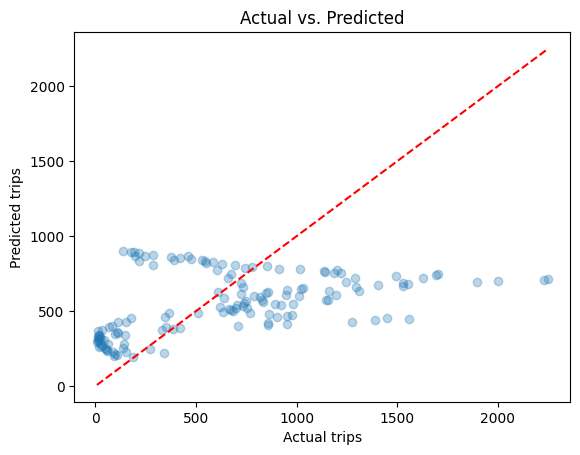

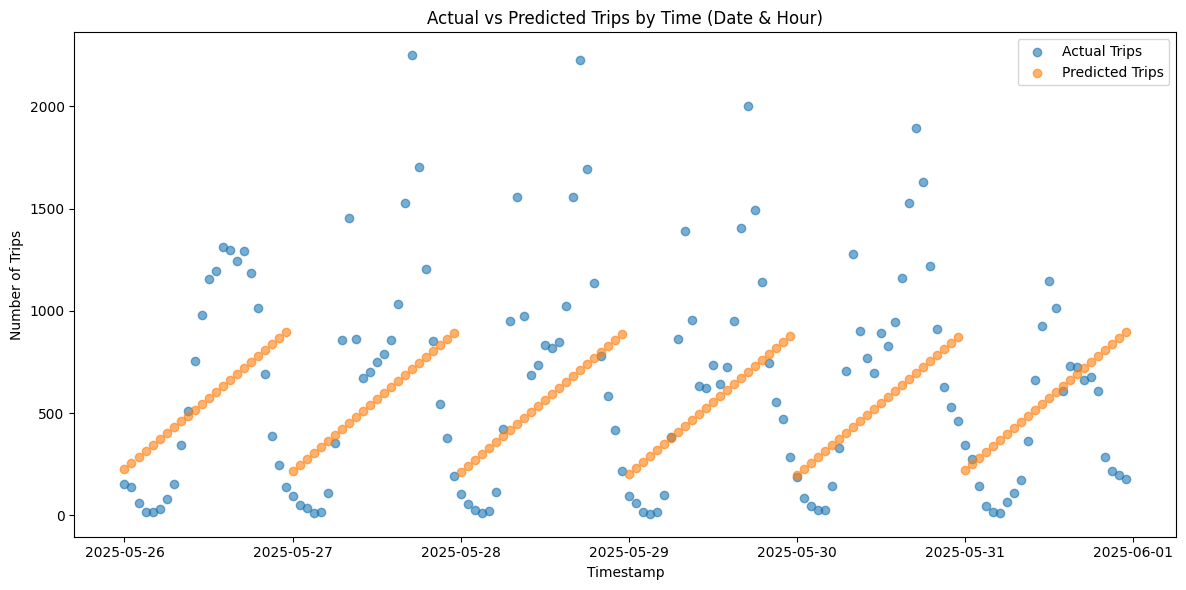

In [18]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual trips")
plt.ylabel("Predicted trips")
plt.title("Actual vs. Predicted")
plt.show()

df = test_with_preds.copy()
df['timestamp'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# 2. Plot
plt.figure(figsize=(12, 6))
plt.scatter(df['timestamp'], df['total_trips'],    label='Actual Trips',    alpha=0.6)
plt.scatter(df['timestamp'], df['predicted_trips'], label='Predicted Trips', alpha=0.6)
plt.xlabel('Timestamp')
plt.ylabel('Number of Trips')
plt.title('Actual vs Predicted Trips by Time (Date & Hour)')
plt.legend()
plt.tight_layout()
plt.show()

All trainings


In [21]:
from sklearn.utils import all_estimators
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# 1. Gather all regressor classes
all_regs = all_estimators(type_filter='regressor')

# 2. Prepare your time-series split
tscv = TimeSeriesSplit(n_splits=3)

results = []
for name, Regressor in all_regs:
    try:
        # instantiate with default params
        model = Regressor()

        maes, rmses = [], []
        for train_idx, val_idx in tscv.split(X_train):
            X_tr,   X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr,   y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_hat = model.predict(X_val)

            maes.append(mean_absolute_error(y_val, y_hat))
            rmses.append(mean_squared_error(y_val, y_hat, squared=False))

        results.append({
            'model': name,
            'mean_MAE':  sum(maes) / len(maes),
            'mean_RMSE': sum(rmses) / len(rmses)
        })
    except Exception:
        # some estimators will error out—just skip them
        continue

# 3. Display a leaderboard
leaderboard = pd.DataFrame(results).sort_values('mean_MAE').reset_index(drop=True)
leaderboard.head(10)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _choles

KeyError: 'mean_MAE'

## Quick “API” in Colab (Flask Demo)?